## What kind of images are we going to show the model?

We want to use a UNet model, our images are of size 768x768.
It would be ideal if our output mask would be 256x256 because 768/3 = 256, so
by using this output size we can divide our image into 3x3 squares. 

In our training phase we want to show as many ships as we can to our model,
so it can learn the different variations of them. In order to achive this
we will crop out a ship from an image. In the test and validation sets we will
not use this technique, we are going to go through our images normally.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Here we have each segmentation for a ship
imgs_dir = Path('data/processed/train/')
segmentations = pd.read_csv('data/processed/train_ship_segmentations.csv')
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].fillna('')
segmentations.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
# Here we grouped the images, so EncodedPixels contains all ship segmentations on that image
seg_by_img = segmentations.groupby('ImageId').aggregate({ 'EncodedPixels': ' '.join })
seg_by_img.head()

,EncodedPixels
ImageId,
00003e153.jpg,
0001124c7.jpg,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg,


In [4]:
# Function to decode run length encoding of image segmentation
def decode_rle(rle: str, img_size: tuple[int,int]) -> np.ndarray:
    """Decodes run length encoding into a mask that is the size of img_size.
    
    Args:
        rle (str): The run length encoding
        img_size (tuple[int, int]): The size of the original image (width, height)
    """
    rle = rle.split()
    starts, lengths = [np.asarray(x, dtype=int)
                        for x in (rle[0:][::2], rle[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(img_size[0]*img_size[1], dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    mask = mask.reshape((img_size[1], img_size[0]))
    return mask.transpose()

In [5]:
def bbox(mask: np.ndarray):
    """Returns the bounding box of the mask."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [6]:
# First lets collect some data about the size of ships
widths = []
heights = []
for rle in segmentations['EncodedPixels']:
    if rle != '':
        ship_mask = decode_rle(rle, (768, 768))
        ymin, ymax, xmin, xmax = bbox(ship_mask)
        widths.append(xmax-xmin)
        heights.append(ymax-ymin)
    else:
        widths.append(0)
        heights.append(0)
segmentations['width'], segmentations['height'] = widths, heights

# See how do ship sizes compare to image sizes, 
# as you can see they are a lot smaller
segmentations.describe()

,width,height
count,88997.000000,88997.000000
mean,42.454218,34.476409
std,55.386969,44.288797
min,0.000000,0.000000
25%,8.000000,7.000000
50%,20.000000,18.000000
75%,58.000000,46.000000
max,443.000000,334.000000


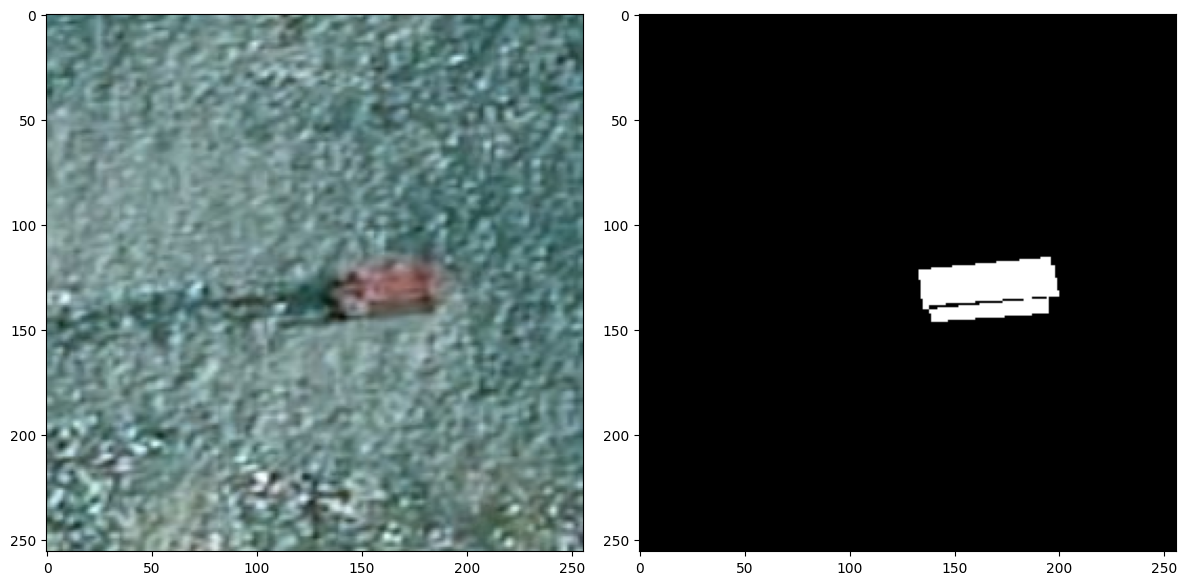

In [7]:
# Get relevant part of image
index = 50 # The index of the image in the dataset

seg_with_ship = segmentations[segmentations['EncodedPixels'] != '']
seg_with_ship.reset_index(inplace=True)
img_id, rle = seg_with_ship.loc[index, ['ImageId', 'EncodedPixels']].tolist()

img = Image.open(imgs_dir / img_id)

ship_mask = decode_rle(rle, (img.width, img.height))
ymin, ymax, xmin, xmax = bbox(ship_mask)
bheight, bwidth = ymax-ymin, xmax-xmin
if bheight < 256:
    ymin = max(0, ymin - (256 - bheight)//2)
    ymax = min(img.height, ymax + (256 - bheight)//2)
if bwidth < 256:
    xmin = max(0, xmin - (256 - bwidth)//2)
    xmax = min(img.width, xmax + (256 - bwidth)//2)

mask = decode_rle(seg_by_img.loc[img_id, 'EncodedPixels'], (img.width, img.height))
mask = Image.fromarray(mask)

mask = mask.crop(((xmin, ymin, xmax, ymax))).resize((256, 256))
img = img.crop((xmin, ymin, xmax, ymax)).resize((256, 256))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(img)
plt.subplot(1, 2, 2); plt.imshow(mask)
plt.tight_layout()

## Validation dataset

Going through some training loops, we discovered a problem with our original validation dataset.
So originally we divided each image into 3x3 equal parts, but we have 3000 images thats 27000 images
to evaluate for the model, thats a lot. Another problem with this approach is that our evaluation is
not going to be representative of the model's performance because most of the images contain water,
and it is easy for the model to classify it as background this will tilt our evaluation process.

**Solution**: We only show image parts that contain ships, this way we can throw away lot of the useless images
and get a more accurate score of the model's performance.

In [8]:
imgs_dir = Path('data/processed/val/')
segmentations = pd.read_csv('data/processed/val_ship_segmentations.csv')
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].fillna('')
segmentations.head()

,ImageId,EncodedPixels
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...


In [9]:
# Filter whole images that do not contain ships
segmentations = segmentations[segmentations['EncodedPixels'] != '']
segmentations.head()

,ImageId,EncodedPixels
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...


array([6])

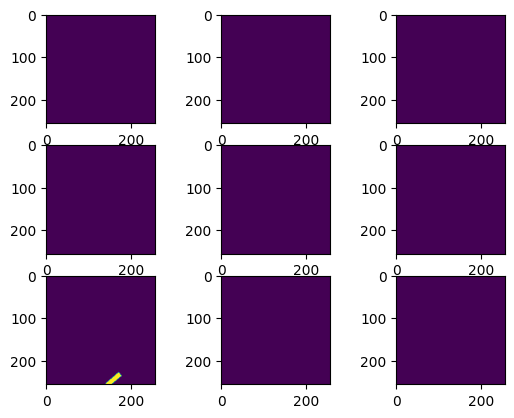

In [10]:
# Decode which 256x256 part of image contains the ship
rle = segmentations.iloc[0, 1]

def ship_position(rle: str):
    mask = decode_rle(rle, (768, 768))
    parts = mask.reshape(3, 256, 3, 256)
    return np.nonzero(parts.any(axis=(1, 3)).flatten())[0]

mask = decode_rle(rle, (768, 768))
split = mask.reshape(3, 256, 3, 256).swapaxes(1, 2).reshape(9, 256, 256)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(split[i])

ship_position(rle)

In [11]:
segmentations['ship_position'] = segmentations['EncodedPixels'].apply(ship_position)
segmentations.head()

,ImageId,EncodedPixels,ship_position
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,[6]
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,[6]
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...,[6]
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,[6]
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,[6]


In [12]:
seg_by_img = segmentations.groupby('ImageId').aggregate({
    'EncodedPixels': ' '.join,
    'ship_position': lambda x: np.unique(np.concatenate(x.values))
})
seg_by_img.head()

,EncodedPixels,ship_position
ImageId,,
00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,[6]
001bcf222.jpg,219235 2 219999 6 220764 10 221530 12 222298 1...,[4]
002c62c03.jpg,490805 2 491570 5 492336 8 493104 8 493873 7 4...,[2]
002fdcf51.jpg,373563 2 374331 4 375098 7 375866 9 376633 12 ...,"[4, 5]"
00640a1af.jpg,337819 5 338579 13 339343 17 340111 17 340879 ...,"[0, 5, 7]"


In [13]:
idx_to_dfi = []
for i, positions in enumerate(seg_by_img['ship_position'].values):
    idx_to_dfi.extend([(i, p) for p in positions])
idx_to_dfi[:5]

[(0, 6), (1, 4), (2, 2), (3, 4), (3, 5)]